In [1]:
import sys
sys.path.append("..")
import Data as dt
import ChevalParesseux_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Sets the number of jobs to use for parallel processing
n_jobs = 5

In [2]:
# I. Load data
data = dt.load_data(ticker='SPY')
data['code'] = 'SPY'

# II. Making Samples (we use a temporal sampling here)
full_size = len(data)

training_data = data.iloc[0 : int(full_size * 0.7)].copy()
testing_data = data.loc[int(full_size * 0.7) + 1 : int(full_size * 0.9)].copy()
embargo_data = data.loc[int(full_size * 0.9) + 1 :].copy()

In [3]:
processed_train = training_data.copy()

# ======= I. Set up the labeller =======
labeller = lib.TripleBarrier_labeller(n_jobs=n_jobs)
labeller_params = {
    "upper_barrier": [1.5],
    "lower_barrier": [1],
    "vertical_barrier": [21],
    "vol_window": [21],
    "smoothing_method": ['ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
labeller.set_params(**labeller_params)

# ======= II. Extract the labels =======
labels_df = labeller.extract(data=processed_train['close'])
processed_train['label'] = labels_df[labels_df.columns[0]]

### ***Features Extraction***

In [4]:
import numpy as np
import pandas as pd
from typing import Union, Self
from abc import ABC, abstractmethod
from joblib import Parallel, delayed



#! ==================================================================================== #
#! ================================= Base Model ======================================= #
class Feature(ABC):
    """
    Abstract base class for all features.
    
    This class defines the core structure and interface for feature extraction. It is meant to be subclassed
    by specific feature implementations. 
    Subclasses must implement the following abstract methods:
        - __init__: Initializes the feature with name, and optionally number of jobs.
        - set_params: Defines the parameter grid as a dictionary of lists.
        - process_data: Applies preprocessing to the data.
        - get_feature: Extracts the actual feature(s), returning a DataFrame.

    Main usage involves one core methods:
        - smooth_data: Applies optional smoothing to the input data before feature computation.
        - extract: Returns extracted features.
    """
    #?_____________________________ Initialization methods _______________________________ #
    @abstractmethod
    def __init__(
        self, 
        name: str, 
        n_jobs: int = 1
    ):
        """
        Constructor for the Feature class.
        
        Parameters:
            - name (str): The name identifier for the feature.
            - n_jobs (int): Number of parallel jobs to use during feature computation.
        """
        # ======= I. Initialize Class =======
        self.name = name
        self.n_jobs = n_jobs

        # ======= II. Initialize Auxilaries =======
        self.params = {}
    
    #?____________________________________________________________________________________ #
    @abstractmethod
    def set_params(
        self,
        **kwargs
    ) -> Self:
        """
        Sets the parameter grid for the feature extraction.

        Parameters:
            - **kwargs: Each parameter should be a list of possible values.
                    Example: feature.set_params(window=[5, 10], threshold=[3, 4])

        Returns:
            - Self: The instance of the class with the parameter grid set.
        """
        ...

    #?________________________________ Auxiliary methods _________________________________ #
    @abstractmethod
    def process_data(
        self,
        data: Union[tuple, pd.Series, pd.DataFrame],
        **kwargs
    ) -> Union[tuple, pd.DataFrame, pd.Series]:
        """
        Preprocesses the data before feature extraction.

        Parameters:
            - data (tuple | pd.Series | pd.DataFrame): The input data to be processed.
            - **kwargs: Additional parameters for the data processing.

        Returns:
            - tuple or pd.DataFrame or pd.Series: The processed data ready for feature extraction.
        """
        ...
    
    #?____________________________________________________________________________________ #
    @abstractmethod
    def get_feature(
        self,
        data: Union[tuple, pd.Series, pd.DataFrame],
        **kwargs
    ) -> pd.Series:
        """
        Core method for feature extraction.
        
        Parameters:
            - data (tuple | pd.Series | pd.DataFrame): The input data to extract the feature from
            - **kwargs: Additional parameters for the feature extraction.
        
        Returns:
            - pd.Series : The extracted feature as a pd.Series.
        """
        ...
       
    #?____________________________________________________________________________________ #
    def smooth_data(
        self, 
        data: pd.Series,
        smoothing_method: str = None, 
        window_smooth: int = None, 
        lambda_smooth: float = None
    ):
        """
        Applies optional smoothing to the input data before feature computation.

        Parameters:
            - data (pd.Series): The input data to be processed.
            - smoothing_method (str): Type of smoothing to apply. Options: "ewma", "average", or None.
            - window_smooth (int): Size of the smoothing window.
            - lambda_smooth (float): EWMA decay parameter in [0, 1].

        Returns:
            - smoothed_data (pd.Series): The smoothed series, or raw series if no smoothing is applied.
        """
        # ======= I. Check if any smoothing should be applied =======
        if smoothing_method is None:
            return data
        
        # ======= II. Compute the smoothed series =======
        elif smoothing_method == "ewma":
            smoothed_data = lib.ewma_smoothing(price_series=data, window=window_smooth, ind_lambda=lambda_smooth)
        elif smoothing_method == "average":
            smoothed_data = lib.average_smoothing(price_series=data, window=window_smooth)
            
        else:
            raise ValueError("Smoothing method not recognized")
        
        return smoothed_data
    
    #?_________________________________ Callable methods _________________________________ #
    def extract(
        self, 
        data: Union[tuple, pd.Series, pd.DataFrame]
    ) -> pd.DataFrame:
        """
        Main method to extract features.

        Parameters:
            - data (tuple | pd.Series | pd.DataFrame): The input data to extract the feature from
        
        Returns:
            - features_df (pd.DataFrame): The extracted features as a DataFrame.
        """
        # ======= I. Extract the Parameters Universe =======
        params_grid = lib.get_dict_universe(self.params)

        # ======= II. Extract the features for each Parameters =======
        features = Parallel(n_jobs=self.n_jobs)(delayed(self.get_feature)(data, **params) for params in params_grid)

        # ======= III. Create a DataFrame with the features =======
        features_df = pd.concat(features, axis=1)

        return features_df

#! ================================= Example ======================================= #
class Average_feature(Feature):
    """
    Moving Average Feature

    This class computes the normalized moving average of a time series, with optional pre-smoothing filters.
    It inherits from the Feature base class and implements methods to:
        - set_params : define parameter grids.
        - process_data : optionally performs preprocessing on the input series.
        - get_feature : compute the moving average feature over a rolling window
    """
    def __init__(
        self, 
        name: str = "average" , 
        n_jobs: int = 1
    ) -> None:
        """
        Initializes the average_feature object with input data, name, and parallel jobs.
        
        Parameters:
            - name (str): Name of the feature, used in column labeling.
            - n_jobs (int): Number of jobs to run in parallel for feature extraction.
        """
        super().__init__(
            name=name, 
            n_jobs=n_jobs,
        )
    
    #?____________________________________________________________________________________ #
    def set_params(
        self,
        window: list = [5, 10, 30, 60],
        smoothing_method: list = [None, "ewma", "average"],
        window_smooth: list = [5, 10],
        lambda_smooth: list = [0.1, 0.2, 0.5],
    ) -> Self:
        """
        Defines the parameter grid for feature extraction.

        Parameters:
            - window (list): Rolling window sizes for the moving average.
            - smoothing_method (list): Type of pre-smoothing to apply. Options: None, "ewma", "average".
            - window_smooth (list): Window size for smoothing methods.
            - lambda_smooth (list): Smoothing factor for EWMA, in [0, 1].
        """
        self.params = {
            "window": window,
            "smoothing_method": smoothing_method,
            "window_smooth": window_smooth,
            "lambda_smooth": lambda_smooth,
        }

        return self

    #?____________________________________________________________________________________ #
    def process_data(
        self, 
        data: pd.Series,
    ) -> pd.Series:
        """
        Applies preprocessing to the input data before feature extraction.
        
        Parameters:
            - data (pd.Series): The input data to be processed.
        
        Returns:
            - processed_data (pd.Series): The resetted index series.
        """
        processed_data = data.copy()
        processed_data.reset_index(drop=True, inplace=True)

        return processed_data
    
    #?____________________________________________________________________________________ #
    def get_feature(
        self,
        data: pd.Series,
        window: int,
        smoothing_method: str,
        window_smooth: int,
        lambda_smooth: float,
    ) -> pd.Series:
        """
        Computes the normalized rolling average of the processed series.

        Parameters: 
            - data (pd.Series): The input series to be processed.
            - window (int): Rolling window size for the moving average.
            - smoothing_method (str): Smoothing method used.
            - window_smooth (int): Smoothing window size.
            - lambda_smooth (float): Smoothing parameter for EWMA.

        Returns:
            - rolling_average (pd.Series): The resulting normalized moving average feature.
        """
        # ======= I. Smooth the Data & Preprocess =======
        smoothed_series = self.smooth_data(
            data=data, 
            smoothing_method=smoothing_method, 
            window_smooth=window_smooth, 
            lambda_smooth=lambda_smooth
        )
        
        processed_series = self.process_data(data=smoothed_series)

        # ======= II. Compute the moving average =======
        rolling_average = processed_series.rolling(window=window).apply(np.mean, raw=False)

        # ======= III. Convert to pd.Series and Center =======
        rolling_average = (pd.Series(rolling_average, index=processed_series.index) / (processed_series + 1e-8)) - 1
        
        # ======= IV. Change Name =======
        rolling_average.name = f"{self.name}_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}"
        rolling_average.index = data.index

        return rolling_average


In [5]:
general_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}

In [6]:
kama_feature = Average_feature(n_jobs=n_jobs)
kama_feature.set_params(**general_params)

kama_feature_df = kama_feature.extract(data=processed_train['close'])

<Axes: >

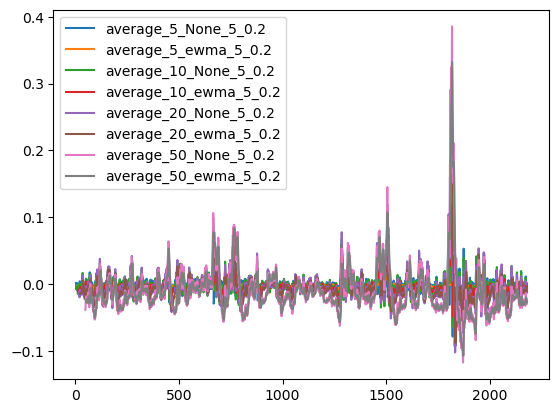

In [8]:
kama_feature_df.plot()

In [ ]:
class Kama_feature(Feature):
    """
    Kaufman Adaptive Moving Average Feature

    This class computes the Kaufman Adaptive Moving Average (KAMA) of a time series, with optional pre-smoothing filters.
    It inherits from the Feature base class and implements methods to:
        - set_params : define parameter grids.
        - process_data : optionally performs preprocessing on the input series.
        - get_feature : compute the moving average feature over a rolling window
    """
    def __init__(
        self, 
        name: str = "kama" , 
        n_jobs: int = 1
    ) -> None:
        """
        Initializes the Kama_feature object with input data, name, and parallel jobs.
        
        Parameters:
            - name (str): Name of the feature, used in column labeling.
            - n_jobs (int): Number of jobs to run in parallel for feature extraction.
        """
        super().__init__(name=name, n_jobs=n_jobs)
    
    #?____________________________________________________________________________________ #
    def set_params(
        self,
        window: list = [5, 10, 30, 60],
        smoothing_method: list = [None, "ewma", "average"],
        window_smooth: list = [5, 10],
        lambda_smooth: list = [0.1, 0.2, 0.5],
        fastest_window: list = [2, 5, 10],
        slowest_window: list = [20, 30],
    ) -> Self:
        """
        Sets the parameter grid for the KAMA feature extraction.

        Parameters:
            - window (list): Rolling window sizes for momentum calculation.
            - smoothing_method (list): Type of smoothing to apply before calculation.
            - window_smooth (list): Smoothing window sizes.
            - lambda_smooth (list): Decay factors for EWMA.
            - fastest_window (list): Fastest window sizes for KAMA calculation.
            - slowest_window (list): Slowest window sizes for KAMA calculation.
        """
        self.params = {
            "window": window,
            "smoothing_method": smoothing_method,
            "window_smooth": window_smooth,
            "lambda_smooth": lambda_smooth,
            "fastest_window": fastest_window,
            "slowest_window": slowest_window,
        }

        return self

    #?____________________________________________________________________________________ #
    def process_data(
        self, 
        data: pd.Series,
    ) -> pd.Series:
        """
        Preprocesses the input data before feature extraction.
        
        Parameters:
            - data (pd.Series): The input data to be processed.
        
        Returns:
            - processed_data (pd.Series): The resetted index series.
        """
        processed_data = data.copy()
        processed_data.reset_index(drop=True, inplace=True)

        return processed_data
    
    #?____________________________________________________________________________________ #
    def get_feature(
        self,
        data: pd.Series,
        window: int,
        smoothing_method: str,
        window_smooth: int,
        lambda_smooth: float,
        fastest_window: int,
        slowest_window: int,
    ) -> pd.Series:
        """
        Computes the normalized Kaufman Adaptive Moving Average (KAMA) of the processed series.
        
        Parameters:
            - data (pd.Series): The input series to be processed.
            - window (int): Rolling window size for the KAMA calculation.
            - smoothing_method (str): Smoothing method used.
            - window_smooth (int): Smoothing window size.
            - lambda_smooth (float): Smoothing parameter for EWMA.
            - fastest_window (int): Fastest window size for KAMA calculation.
            - slowest_window (int): Slowest window size for KAMA calculation.
        
        Returns:
            - rolling_kama (pd.Series): The resulting normalized KAMA feature.
        """
        # ======= I. Smooth the Data & Preprocess =======
        smoothed_series = self.smooth_data(
            data=data, 
            smoothing_method=smoothing_method, 
            window_smooth=window_smooth, 
            lambda_smooth=lambda_smooth
        )
        
        processed_series = self.process_data(data=smoothed_series)

        # ======= II. Compute the rolling kama =======
        rolling_kama = processed_series.rolling(window=window ).apply(get_kama, args=(fastest_window, slowest_window), raw=False)
        
        # ======= III. Convert to pd.Series and Center =======
        rolling_kama = (pd.Series(rolling_kama, index=processed_series.index) / (processed_series + 1e-8)) - 1
        
        # ======= IV. Change Name =======
        rolling_kama.name = f"{self.name}_f{fastest_window}_s{slowest_window}_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}"
        rolling_kama.index = data.index

        return rolling_kama

#*_____________________________________________________________________________________ #
def get_kama(
    series: pd.Series,
    fastest_window: int,
    slowest_window: int,
) -> float:
    """
    Computes the Kaufman Adaptive Moving Average (KAMA) for the last two points in a series.
    
    Parameters:
        - series (pd.Series): The input series containing price data.
        - fastest_window (int): The window size for the fastest smoothing constant.
        - slowest_window (int): The window size for the slowest smoothing constant.
    
    Returns:
        - float: The KAMA value for the last point in the series.
    """
    # ======= I. Inputs =======  
    slowest_window = min(slowest_window, len(series) - 2)
    
    fast_sc = 2 / (fastest_window + 1)
    slow_sc = 2 / (slowest_window + 1)
    
    # ======= II. Compute KAMA value for t-1 =======
    change_t0 = abs(series.iloc[-2] - series.iloc[-2 - slowest_window])
    vol_t0 = series.diff().abs().iloc[-2 - slowest_window + 1 : -1].sum()
    efficiency_ratio_t0 = change_t0 / (vol_t0 + 1e-8)

    smoothing_constant_t0 = (efficiency_ratio_t0 * (fast_sc - slow_sc) + slow_sc) ** 2
    kama_t0 = series.iloc[-3] + smoothing_constant_t0 * (series.iloc[-2] - series.iloc[-3])

    # ======= III. Compute KAMA value for t =======
    change_t1 = abs(series.iloc[-1] - series.iloc[-1 - slowest_window])
    vol_t1 = series.diff().abs().iloc[-1 - slowest_window + 1 :].sum()
    efficiency_ratio_t1 = change_t1 / (vol_t1 + 1e-8)

    smoothing_constant_t1 = (efficiency_ratio_t1 * (fast_sc - slow_sc) + slow_sc) ** 2
    kama_t1 = kama_t0 + smoothing_constant_t1 * (series.iloc[-1] - kama_t0)

    return kama_t1

#!_____________________________________________________________________________________ #
kama_feature = Kama_feature(n_jobs=n_jobs)
kama_params = {
    "window": [20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
    "fastest_window": [2, 5, 10],
    "slowest_window": [20, 30],
}
kama_feature.set_params(**kama_params)

kama_feature_df = kama_feature.extract(data=processed_train['close'])

In [ ]:
class StochasticRSI_feature(Feature):
    """
    """
    def __init__(
        self, 
        name: str = "stochastic_rsi", 
        n_jobs: int = 1
    ) -> None:
        """
        """
        super().__init__(
            name=name,
            n_jobs=n_jobs,
        )
    
    #?____________________________________________________________________________________ #
    def set_params(
        self,
        window: list = [5, 10, 30, 60],
        smoothing_method: list = [None, "ewma", "average"],
        window_smooth: list = [5, 10],
        lambda_smooth: list = [0.1, 0.2, 0.5],
    ) -> Self:
        """
        Sets the parameter grid for momentum feature extraction.

        Parameters:
            - window (list): Rolling window sizes for momentum calculation.
            - smoothing_method (list): Type of smoothing to apply before calculation.
            - window_smooth (list): Smoothing window sizes.
            - lambda_smooth (list): Decay factors for EWMA.
        """
        self.params = {
            "window": window,
            "smoothing_method": smoothing_method,
            "window_smooth": window_smooth,
            "lambda_smooth": lambda_smooth,
        }

        return self

    #?____________________________________________________________________________________ #
    def process_data(
        self, 
        data: pd.Series,
    ) -> pd.Series:
        """
        """
        processed_data = data.copy()
        processed_data.reset_index(drop=True, inplace=True)

        return processed_data
    
    #?____________________________________________________________________________________ #
    def get_feature(
        self,
        data: pd.Series,
        window: int,
        smoothing_method: str,
        window_smooth: int,
        lambda_smooth: float,
    ) -> pd.Series:
        """
        """
        # ======= I. Smooth the Data & Preprocess =======
        smoothed_series = self.smooth_data(
            data=data, 
            smoothing_method=smoothing_method, 
            window_smooth=window_smooth, 
            lambda_smooth=lambda_smooth
        )
        
        processed_series = self.process_data(data=smoothed_series)

        # ======= II. Compute the moving momentum =======
        rolling_stoch_rsi = processed_series.rolling(window=window ).apply(get_stochastic_rsi, raw=False)
        
        # ======= III. Convert to pd.Series and Center =======
        rolling_stoch_rsi = pd.Series(rolling_stoch_rsi, index=processed_series.index) 
        
        # ======= IV. Change Name =======
        rolling_stoch_rsi.name = f"{self.name}_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}"
        rolling_stoch_rsi.index = data.index

        return rolling_stoch_rsi

#*_____________________________________________________________________________________ #
def get_stochastic_rsi(
    series: pd.Series
) -> float:
    """
    Computes the Stochastic RSI for a given price series.
    
    Parameters:
        - series (pd.Series): Price series to compute Stochastic RSI on.
    
    Returns:
        - float: The Stochastic RSI value for the last point in the series.
    """
    # ========== 0. Define a function to compute the Stochastic RSI =======
    def get_relative_strength_index(
        series: pd.Series
    ) -> pd.Series:
        """
        Computes the Relative Strength Index (RSI) for a given price series.
        
        Parameters:
            - series (pd.Series): Price series to compute RSI on.
        
        Returns:
            - pd.Series: The RSI values for the input series.
        """
        # ======= I. Compute Gain and Loss =======
        delta = series.diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)

        # ======= II. Compute Average Gain and Loss =======
        avg_gain = gain.rolling(window=int(len(series) / 2)).mean()
        avg_loss = loss.rolling(window=int(len(series) / 2)).mean()

        # ======= III. Compute Relative Strength and RSI =======
        rs = avg_gain / (avg_loss + 1e-8)
        rsi = 100 - (100 / (1 + rs))

        return rsi
    
    # ======= I. Compute the Relative Strength Index (RSI) =======
    rsi = get_relative_strength_index(series)

    # ======= II. Extract last few RSI values to get the range for StochRSI =======
    rsi_values = rsi.dropna()
    if len(rsi_values) == 0:
        return np.nan

    last_rsi = rsi_values.iloc[-1]
    min_rsi = rsi_values.min()
    max_rsi = rsi_values.max()

    # ======= III. Compute Stochastic RSI =======
    stoch_rsi = (last_rsi - min_rsi) / (max_rsi - min_rsi + 1e-8)
    
    return stoch_rsi

#!_____________________________________________________________________________________ #
stochrsi_feature = Kama_feature(n_jobs=n_jobs)
stochrsi_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
stochrsi_feature.set_params(**stochrsi_params)

stochrsi_feature_df = stochrsi_feature.extract(data=processed_train['close'])

In [ ]:
class RSI_feature(Feature):
    """
    """
    def __init__(
        self, 
        name: str = "rsi", 
        n_jobs: int = 1
    ) -> None:
        """
        """
        super().__init__(
            name=name,
            n_jobs=n_jobs,
        )
    
    #?____________________________________________________________________________________ #
    def set_params(
        self,
        window: list = [5, 10, 30, 60],
        smoothing_method: list = [None, "ewma", "average"],
        window_smooth: list = [5, 10],
        lambda_smooth: list = [0.1, 0.2, 0.5],
    ) -> Self:
        """
        Sets the parameter grid for momentum feature extraction.

        Parameters:
            - window (list): Rolling window sizes for momentum calculation.
            - smoothing_method (list): Type of smoothing to apply before calculation.
            - window_smooth (list): Smoothing window sizes.
            - lambda_smooth (list): Decay factors for EWMA.
        """
        self.params = {
            "window": window,
            "smoothing_method": smoothing_method,
            "window_smooth": window_smooth,
            "lambda_smooth": lambda_smooth,
        }

        return self

    #?____________________________________________________________________________________ #
    def process_data(
        self, 
        data: pd.Series,
    ) -> pd.Series:
        """
        """
        processed_data = data.copy()
        processed_data.reset_index(drop=True, inplace=True)

        return processed_data
    
    #?____________________________________________________________________________________ #
    def get_feature(
        self,
        data: pd.Series,
        window: int,
        smoothing_method: str,
        window_smooth: int,
        lambda_smooth: float,
    ) -> pd.Series:
        """
        """
        # ======= I. Smooth the Data & Preprocess =======
        smoothed_series = self.smooth_data(
            data=data, 
            smoothing_method=smoothing_method, 
            window_smooth=window_smooth, 
            lambda_smooth=lambda_smooth
        )
        
        processed_series = self.process_data(data=smoothed_series)

        # ======= II. Compute the moving momentum =======
        rolling_rsi = processed_series.rolling(window=window ).apply(get_relative_strength_index, raw=False)
        
        # ======= III. Convert to pd.Series and Center =======
        rolling_rsi = pd.Series(rolling_rsi, index=processed_series.index) 
        
        # ======= IV. Change Name =======
        rolling_rsi.name = f"{self.name}_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}"
        rolling_rsi.index = data.index

        return rolling_rsi

#*_____________________________________________________________________________________ #
def get_relative_strength_index(
    series: pd.Series
) -> float:
    """
    """
    # ======= I. Compute Gain and Loss =======
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    # ======= II. Compute Average Gain and Loss =======
    avg_gain = gain.rolling(window=len(series)).mean()
    avg_loss = loss.rolling(window=len(series)).mean()

    # ======= III. Compute Relative Strength and RSI =======
    rs = avg_gain / (avg_loss + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    
    return rsi.iloc[-1]

#!_____________________________________________________________________________________ #
rsi_feature = Kama_feature(n_jobs=n_jobs)
rsi_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
rsi_feature.set_params(**rsi_params)

rsi_feature_df = rsi_feature.extract(data=processed_train['close'])

In [ ]:
class EhlersFisher_feature(Feature):
    """
    """
    def __init__(
        self, 
        name: str = "ehlers_fisher", 
        n_jobs: int = 1
    ) -> None:
        """
        Initializes the Cointegration_feature object.

        Parameters:
            - name (str): Feature name.
            - n_jobs (int): Number of parallel jobs to use.
        """
        super().__init__(
            name=name,
            n_jobs=n_jobs,
        )

    #?____________________________________________________________________________________ #
    def set_params(
        self, 
        window: list = [5, 10, 30, 60], 
        smoothing_method: list = [None, "ewma", "average"], 
        window_smooth: list = [5, 10], 
        lambda_smooth: list = [0.1, 0.2, 0.5]
    ) -> Self:
        """
        Sets the parameter grid for cointegration feature extraction.

        Parameters:
            - window (list): Rolling window sizes for cointegration tests.
            - smoothing_method (list): Smoothing method to apply before testing.
            - window_smooth (list): Smoothing window sizes.
            - lambda_smooth (list): Decay factors for EWMA smoothing.
        """
        self.params = {
            "window": window,
            "smoothing_method": smoothing_method,
            "window_smooth": window_smooth,
            "lambda_smooth": lambda_smooth,
        }
        
        return self

    #?____________________________________________________________________________________ #
    def process_data(
        self, 
        data: Union[tuple, pd.DataFrame],
    ) -> tuple:
        """
        """
        # ======= I. Extract Series =======
        if isinstance(data, pd.DataFrame):
            nb_series = data.shape[1]
            if nb_series != 2:
                raise ValueError(f"DataFrame must have exactly 2 columns, but got {nb_series}.")
            
            series_high = data.iloc[:, 0]
            series_low = data.iloc[:, 1]
        
        elif isinstance(data, tuple) and len(data) == 2:
            series_high = data[0]
            series_low = data[1]
        else:
            raise ValueError("Data must be either a tuple of two series or a DataFrame with two columns.")
        
        # ======= II. Ensure Series have the same indexation =======
        series_df = pd.DataFrame({"series_high": series_high, "series_low": series_low})
        series_df = series_df.dropna()
        series_high = series_df["series_high"]
        series_low = series_df["series_low"]
        
        # ======= III. Return Processed Data =======    
        processed_data = (series_high, series_low)

        return processed_data

    #?____________________________________________________________________________________ #
    def get_feature(
        self, 
        data: Union[tuple, pd.DataFrame],
        window: int,
        smoothing_method: str,
        window_smooth: int,
        lambda_smooth: float,
    ) -> pd.DataFrame:
        """
        """
        # ======= I. Process Data =======
        processed_data = self.process_data(data=data)
        series_high = processed_data[0]
        series_low = processed_data[1]

        # ======= II. Apply Smoothing if Needed =======
        if smoothing_method is not None:
            series_high = self.smooth_data(data=series_high, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)
            series_low = self.smooth_data(data=series_low, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)

        # ======= II. Ensure the window is not too large =======
        num_obs = len(series_high) - window
        if num_obs <= 0:
            raise ValueError(f"Window size {window} is too large for the given data length {len(series_high)}.")
        
        # ======= III. Initialize Output Arrays =======
        elhers_fisher_values = np.full(num_obs, np.nan)

        # ======== IV. Iterate Over Observations ========
        for i in range(num_obs):
            # IV.1 Extract Time Windows
            series_high_window = series_high.iloc[i : i + window]
            series_low_window = series_low.iloc[i : i + window]

            # IV.2 Perform Elhers Fisher transform Test
            elhers_fisher = get_ehlers_fisher_transform(
                series_high=series_high_window, 
                series_low=series_low_window
            )

            # IV.3 Store Results
            elhers_fisher_values[i] = elhers_fisher

        # ======== V. Create the Final DataFrame ========
        index = series_high.index[window:]
        features_df = pd.DataFrame({
            f"{self.name}_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}": elhers_fisher_values,
        }, index=index)

        return features_df

#*_____________________________________________________________________________________ #
def get_ehlers_fisher_transform(
    series_high: pd.Series, 
    series_low: pd.Series, 
) -> float:
    """
    Computes the Ehlers Fisher Transform on a high-low price window.
    Returns only the last transformed value.
    """
    mid_series = (series_high + series_low) / 2

    min_val = mid_series.min()
    max_val = mid_series.max()
    if max_val - min_val == 0:
        return 0.0  # avoid division by zero

    # Normalize entire series to [-1, 1]
    normalized = 2 * ((mid_series - min_val) / (max_val - min_val)) - 1
    normalized = np.clip(normalized, -0.999, 0.999)

    # Apply Fisher Transform
    fisher = 0.5 * np.log((1 + normalized) / (1 - normalized))

    return fisher.iloc[-1]  # Only return the last value

#!_____________________________________________________________________________________ #
ehlers_fisher_feature = EhlersFisher_feature(n_jobs=n_jobs)
ehlers_fisher_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
ehlers_fisher_feature.set_params(**ehlers_fisher_params)

ehlers_fisher_feature_df = ehlers_fisher_feature.extract(data=processed_train[['high', 'low']])

In [ ]:
class Oscillator_feature(Feature):
    """
    """
    def __init__(
        self, 
        name: str = "oscillator", 
        n_jobs: int = 1
    ) -> None:
        """
        """
        super().__init__(
            name=name,
            n_jobs=n_jobs,
        )
    
    #?____________________________________________________________________________________ #
    def set_params(
        self,
        window: list = [5, 10, 30, 60],
        smoothing_method: list = [None, "ewma", "average"],
        window_smooth: list = [5, 10],
        lambda_smooth: list = [0.1, 0.2, 0.5],
    ) -> Self:
        """
        Sets the parameter grid for momentum feature extraction.

        Parameters:
            - window (list): Rolling window sizes for momentum calculation.
            - smoothing_method (list): Type of smoothing to apply before calculation.
            - window_smooth (list): Smoothing window sizes.
            - lambda_smooth (list): Decay factors for EWMA.
        """
        self.params = {
            "window": window,
            "smoothing_method": smoothing_method,
            "window_smooth": window_smooth,
            "lambda_smooth": lambda_smooth,
        }

        return self

    #?____________________________________________________________________________________ #
    def process_data(
        self, 
        data: pd.Series,
    ) -> pd.Series:
        """
        """
        processed_data = data.copy()
        processed_data.reset_index(drop=True, inplace=True)

        return processed_data
    
    #?____________________________________________________________________________________ #
    def get_feature(
        self,
        data: pd.Series,
        window: int,
        smoothing_method: str,
        window_smooth: int,
        lambda_smooth: float,
    ) -> pd.Series:
        """
        """
        # ======= I. Smooth the Data & Preprocess =======
        smoothed_series = self.smooth_data(
            data=data, 
            smoothing_method=smoothing_method, 
            window_smooth=window_smooth, 
            lambda_smooth=lambda_smooth
        )
        
        processed_series = self.process_data(data=smoothed_series)

        # ======= II. Compute the moving momentum =======
        rolling_oscillator = processed_series.rolling(window=window ).apply(get_oscillator, raw=False)
        
        # ======= III. Convert to pd.Series and Center =======
        rolling_oscillator = pd.Series(rolling_oscillator, index=processed_series.index) 
        
        # ======= IV. Change Name =======
        rolling_oscillator.name = f"{self.name}_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}"
        rolling_oscillator.index = data.index

        return rolling_oscillator

#*_____________________________________________________________________________________ #
def get_oscillator(
    series: pd.Series
) -> float:
    """
    """
    # ======= I. Compute the linear regression slope =======
    linear_reg = np.polyfit(np.arange(len(series)), series, 1)
    slope = linear_reg[0]
    
    # ======= II. Compute the mean and standard deviation =======
    mean = series.mean()
    stdev = series.std()
    
    # ======= III. Compute the oscillator value =======
    last_value = series.iloc[-1]
    oscillator_value = (last_value - (mean + slope * (len(series) - 1) /2)) / (stdev + 1e-8)
    
    return oscillator_value

#!_____________________________________________________________________________________ #
oscillator_feature = Oscillator_feature(n_jobs=n_jobs)
oscillator_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
oscillator_feature.set_params(**oscillator_params)

oscillator_feature_df = oscillator_feature.extract(data=processed_train['close'])

In [ ]:
class Vortex_feature(Feature):
    """
    """
    def __init__(
        self, 
        name: str = "vortex", 
        n_jobs: int = 1
    ) -> None:
        """
        """
        super().__init__(
            name=name,
            n_jobs=n_jobs,
        )

    #?____________________________________________________________________________________ #
    def set_params(
        self, 
        window: list = [5, 10, 30, 60], 
        smoothing_method: list = [None, "ewma", "average"], 
        window_smooth: list = [5, 10], 
        lambda_smooth: list = [0.1, 0.2, 0.5]
    ) -> Self:
        """
        Sets the parameter grid for cointegration feature extraction.

        Parameters:
            - window (list): Rolling window sizes for cointegration tests.
            - smoothing_method (list): Smoothing method to apply before testing.
            - window_smooth (list): Smoothing window sizes.
            - lambda_smooth (list): Decay factors for EWMA smoothing.
        """
        self.params = {
            "window": window,
            "smoothing_method": smoothing_method,
            "window_smooth": window_smooth,
            "lambda_smooth": lambda_smooth,
        }
        
        return self

    #?____________________________________________________________________________________ #
    def process_data(
        self, 
        data: Union[tuple, pd.DataFrame],
    ) -> tuple:
        """
        """
        # ======= I. Extract Series =======
        if isinstance(data, pd.DataFrame):
            nb_series = data.shape[1]
            if nb_series != 3:
                raise ValueError(f"DataFrame must have exactly 3 columns, but got {nb_series}.")
            
            series_mid = data.iloc[:, 0]
            series_high = data.iloc[:, 1]
            series_low = data.iloc[:, 2]
        
        elif isinstance(data, tuple) and len(data) == 3:
            series_mid = data[0]
            series_high = data[1]
            series_low = data[2]
        else:
            raise ValueError("Data must be either a tuple of three series or a DataFrame with three columns.")
        
        # ======= II. Ensure Series have the same indexation =======
        series_df = pd.DataFrame({"series_mid": series_mid, "series_high": series_high, "series_low": series_low})
        series_df = series_df.dropna()
        series_mid = series_df["series_mid"]
        series_high = series_df["series_high"]
        series_low = series_df["series_low"]
        
        # ======= III. Return Processed Data =======    
        processed_data = (series_mid, series_high, series_low)

        return processed_data

    #?____________________________________________________________________________________ #
    def get_feature(
        self, 
        data: Union[tuple, pd.DataFrame],
        window: int,
        smoothing_method: str,
        window_smooth: int,
        lambda_smooth: float,
    ) -> pd.DataFrame:
        """
        """
        # ======= I. Process Data =======
        processed_data = self.process_data(data=data)
        series_mid = processed_data[0]
        series_high = processed_data[1]
        series_low = processed_data[2]

        # ======= II. Apply Smoothing if Needed =======
        if smoothing_method is not None:
            series_mid = self.smooth_data(data=series_mid, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)
            series_high = self.smooth_data(data=series_high, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)
            series_low = self.smooth_data(data=series_low, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)

        # ======= II. Ensure the window is not too large =======
        num_obs = len(series_high) - window
        if num_obs <= 0:
            raise ValueError(f"Window size {window} is too large for the given data length {len(series_high)}.")

        # ======= III. Initialize Output Arrays =======
        vortex_up_values = np.full(num_obs, np.nan)
        vortex_down_values = np.full(num_obs, np.nan)

        # ======== IV. Iterate Over Observations ========
        for i in range(num_obs):
            # IV.1 Extract Time Windows
            series_mid_window = series_mid.iloc[i : i + window]
            series_high_window = series_high.iloc[i : i + window]
            series_low_window = series_low.iloc[i : i + window]

            # IV.2 Perform Elhers Fisher transform Test
            vortex_up, vortex_down = get_vortex(
                series_mid=series_mid_window,
                series_high=series_high_window, 
                series_low=series_low_window
            )

            # IV.3 Store Results
            vortex_up_values[i] = vortex_up
            vortex_down_values[i] = vortex_down

        # ======== V. Create the Final DataFrame ========
        index = series_high.index[window:]
        features_df = pd.DataFrame({
            f"{self.name}_up_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}": vortex_up_values,
            f"{self.name}_down_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}": vortex_down_values,
        }, index=index)

        return features_df

#*_____________________________________________________________________________________ #
def get_vortex(
    series_mid: pd.Series,
    series_high: pd.Series,
    series_low: pd.Series,
) -> float:
    """
    """
    # ======= I. Compute the True Range =======
    true_range = np.maximum(
        series_high - series_low,
        np.abs(series_high - series_mid.shift(1)),
        np.abs(series_low - series_mid.shift(1))
    )
    
    # ======= II. Compute the Vortex Movement =======
    vm_up = np.abs(series_high - series_low.shift(1))
    vm_down = np.abs(series_low - series_high.shift(1))
    
    # ======= III. Compute the Vortex Indicator =======
    vortex_up = vm_up.sum() / true_range.sum() if true_range.sum() != 0 else 0.0
    vortex_down = vm_down.sum() / true_range.sum() if true_range.sum() != 0 else 0.0
    
    # ======= IV. Ensure no outliers =======
    if np.abs(vortex_up) > 3 or np.abs(vortex_down) > 3:
        vortex_up, vortex_down = 1, 1

    return vortex_up, vortex_down

#!_____________________________________________________________________________________ #
vortex_feature = Vortex_feature(n_jobs=1)
vortex_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
vortex_feature.set_params(**vortex_params)
vortex_feature_df = vortex_feature.extract(data=processed_train[['close', 'high', 'low']])

In [ ]:
class Vigor_feature(Feature):
    """
    """
    def __init__(
        self, 
        name: str = "vigor", 
        n_jobs: int = 1
    ) -> None:
        """
        """
        super().__init__(
            name=name,
            n_jobs=n_jobs,
        )

    #?____________________________________________________________________________________ #
    def set_params(
        self, 
        window: list = [5, 10, 30, 60], 
        smoothing_method: list = [None, "ewma", "average"], 
        window_smooth: list = [5, 10], 
        lambda_smooth: list = [0.1, 0.2, 0.5]
    ) -> Self:
        """
        Sets the parameter grid for cointegration feature extraction.

        Parameters:
            - window (list): Rolling window sizes for cointegration tests.
            - smoothing_method (list): Smoothing method to apply before testing.
            - window_smooth (list): Smoothing window sizes.
            - lambda_smooth (list): Decay factors for EWMA smoothing.
        """
        self.params = {
            "window": window,
            "smoothing_method": smoothing_method,
            "window_smooth": window_smooth,
            "lambda_smooth": lambda_smooth,
        }
        
        return self

    #?____________________________________________________________________________________ #
    def process_data(
        self, 
        data: Union[tuple, pd.DataFrame],
    ) -> tuple:
        """
        """
        # ======= I. Extract Series =======
        if isinstance(data, pd.DataFrame):
            nb_series = data.shape[1]
            if nb_series != 4:
                raise ValueError(f"DataFrame must have exactly 4 columns, but got {nb_series}.")
            
            series_open = data.iloc[:, 0]
            series_close = data.iloc[:, 1]
            series_high = data.iloc[:, 2]
            series_low = data.iloc[:, 3]
        
        elif isinstance(data, tuple) and len(data) == 4:
            series_open = data[0]
            series_close = data[1]
            series_high = data[2]
            series_low = data[3]
        else:
            raise ValueError("Data must be either a tuple of four series or a DataFrame with four columns.")
        
        # ======= II. Ensure Series have the same indexation =======
        series_df = pd.DataFrame({"series_open": series_open, "series_close": series_close, "series_high": series_high, "series_low": series_low})
        series_df = series_df.dropna()
        
        series_open = series_df["series_open"]
        series_close = series_df["series_close"]
        series_high = series_df["series_high"]
        series_low = series_df["series_low"]
        
        # ======= III. Return Processed Data =======    
        processed_data = (series_open, series_close, series_high, series_low)

        return processed_data

    #?____________________________________________________________________________________ #
    def get_feature(
        self, 
        data: Union[tuple, pd.DataFrame],
        window: int,
        smoothing_method: str,
        window_smooth: int,
        lambda_smooth: float,
    ) -> pd.DataFrame:
        """
        """
        # ======= I. Process Data =======
        processed_data = self.process_data(data=data)
        series_open = processed_data[0]
        series_close = processed_data[1]
        series_high = processed_data[2]
        series_low = processed_data[3]

        # ======= II. Apply Smoothing if Needed =======
        if smoothing_method is not None:
            series_open = self.smooth_data(data=series_open, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)
            series_close = self.smooth_data(data=series_close, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)
            series_high = self.smooth_data(data=series_high, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)
            series_low = self.smooth_data(data=series_low, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)

        # ======= II. Ensure the window is not too large =======
        num_obs = len(series_high) - window
        if num_obs <= 0:
            raise ValueError(f"Window size {window} is too large for the given data length {len(series_high)}.")

        # ======= III. Initialize Output Arrays =======
        vigor_values = np.full(num_obs, np.nan)

        # ======== IV. Iterate Over Observations ========
        for i in range(num_obs):
            # IV.1 Extract Time Windows
            series_open_window = series_open.iloc[i : i + window]
            series_close_window = series_close.iloc[i : i + window]
            series_high_window = series_high.iloc[i : i + window]
            series_low_window = series_low.iloc[i : i + window]

            # IV.2 Perform Elhers Fisher transform Test
            vigor_index = get_vigor(
                series_open=series_open_window,
                series_close=series_close_window,
                series_high=series_high_window, 
                series_low=series_low_window
            )

            # IV.3 Store Results
            vigor_values[i] = vigor_index

        # ======== V. Create the Final DataFrame ========
        index = series_high.index[window:]
        features_df = pd.DataFrame({
            f"{self.name}_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}": vigor_values,
        }, index=index)

        return features_df

#*_____________________________________________________________________________________ #
def get_vigor(
    series_open: pd.Series,
    series_close: pd.Series,
    series_high: pd.Series,
    series_low: pd.Series,
) -> float:
    """
    """
    # ======= I. Compute vigor index =======
    vigor = (series_close - series_open) / (series_high - series_low + 1e-8)
    vigor_index = vigor.iloc[-1]  # Return only the last value
    
    return vigor_index

#!_____________________________________________________________________________________ #
vigor_feature = Vigor_feature(n_jobs=n_jobs)
vigor_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
vigor_feature.set_params(**vigor_params)
vigor_feature_df = vigor_feature.extract(data=processed_train[['open', 'close', 'high', 'low']])

In [ ]:
class StochasticOscillator_feature(Feature):
    """
    """
    def __init__(
        self, 
        name: str = "stochoscillator", 
        n_jobs: int = 1
    ) -> None:
        """
        """
        super().__init__(
            name=name,
            n_jobs=n_jobs,
        )

    #?____________________________________________________________________________________ #
    def set_params(
        self, 
        window: list = [5, 10, 30, 60], 
        smoothing_method: list = [None, "ewma", "average"], 
        window_smooth: list = [5, 10], 
        lambda_smooth: list = [0.1, 0.2, 0.5]
    ) -> Self:
        """
        Sets the parameter grid for cointegration feature extraction.

        Parameters:
            - window (list): Rolling window sizes for cointegration tests.
            - smoothing_method (list): Smoothing method to apply before testing.
            - window_smooth (list): Smoothing window sizes.
            - lambda_smooth (list): Decay factors for EWMA smoothing.
        """
        self.params = {
            "window": window,
            "smoothing_method": smoothing_method,
            "window_smooth": window_smooth,
            "lambda_smooth": lambda_smooth,
        }
        
        return self

    #?____________________________________________________________________________________ #
    def process_data(
        self, 
        data: Union[tuple, pd.DataFrame],
    ) -> tuple:
        """
        """
        # ======= I. Extract Series =======
        if isinstance(data, pd.DataFrame):
            nb_series = data.shape[1]
            if nb_series != 3:
                raise ValueError(f"DataFrame must have exactly 3 columns, but got {nb_series}.")
            
            series_mid = data.iloc[:, 0]
            series_high = data.iloc[:, 1]
            series_low = data.iloc[:, 2]
        
        elif isinstance(data, tuple) and len(data) == 3:
            series_mid = data[0]
            series_high = data[1]
            series_low = data[2]
        else:
            raise ValueError("Data must be either a tuple of three series or a DataFrame with three columns.")
        
        # ======= II. Ensure Series have the same indexation =======
        series_df = pd.DataFrame({"series_mid": series_mid, "series_high": series_high, "series_low": series_low})
        series_df = series_df.dropna()
        series_mid = series_df["series_mid"]
        series_high = series_df["series_high"]
        series_low = series_df["series_low"]
        
        # ======= III. Return Processed Data =======    
        processed_data = (series_mid, series_high, series_low)

        return processed_data

    #?____________________________________________________________________________________ #
    def get_feature(
        self, 
        data: Union[tuple, pd.DataFrame],
        window: int,
        smoothing_method: str,
        window_smooth: int,
        lambda_smooth: float,
    ) -> pd.DataFrame:
        """
        """
        # ======= I. Process Data =======
        processed_data = self.process_data(data=data)
        series_mid = processed_data[0]
        series_high = processed_data[1]
        series_low = processed_data[2]

        # ======= II. Apply Smoothing if Needed =======
        if smoothing_method is not None:
            series_mid = self.smooth_data(data=series_mid, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)
            series_high = self.smooth_data(data=series_high, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)
            series_low = self.smooth_data(data=series_low, smoothing_method=smoothing_method, window_smooth=window_smooth, lambda_smooth=lambda_smooth)

        # ======= II. Ensure the window is not too large =======
        num_obs = len(series_high) - window
        if num_obs <= 0:
            raise ValueError(f"Window size {window} is too large for the given data length {len(series_high)}.")

        # ======= III. Initialize Output Arrays =======
        fast_oscillator_values = np.full(num_obs, np.nan)
        slow_oscillator_values = np.full(num_obs, np.nan)

        # ======== IV. Iterate Over Observations ========
        for i in range(num_obs):
            # IV.1 Extract Time Windows
            series_mid_window = series_mid.iloc[i : i + window]
            series_high_window = series_high.iloc[i : i + window]
            series_low_window = series_low.iloc[i : i + window]

            # IV.2 Perform Elhers Fisher transform Test
            fast_oscillator, slow_oscillator = get_stochastic_oscillator(
                series_mid=series_mid_window,
                series_high=series_high_window, 
                series_low=series_low_window
            )

            # IV.3 Store Results
            fast_oscillator_values[i] = fast_oscillator
            slow_oscillator_values[i] = slow_oscillator

        # ======== V. Create the Final DataFrame ========
        index = series_high.index[window:]
        features_df = pd.DataFrame({
            f"{self.name}_fast_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}": fast_oscillator_values,
            f"{self.name}_slow_{window}_{smoothing_method}_{window_smooth}_{lambda_smooth}": slow_oscillator_values,
        }, index=index)

        return features_df

#*_____________________________________________________________________________________ #
def get_stochastic_oscillator(
    series_mid: pd.Series,
    series_high: pd.Series,
    series_low: pd.Series,
) -> tuple[float, float]:
    """
    Compute fast (%K) and slow (%D) stochastic oscillator values.

    Parameters:
        - series_mid: pd.Series of close/mid prices
        - series_high: pd.Series of high prices
        - series_low: pd.Series of low prices

    Returns:
        - last_fast_oscillator: last %K value (float)
        - slow_oscillator: mean of last 3 %K values (float)
    """
    # ======= I. Compute rolling %K values =======
    lowest_low = series_low.min()
    highest_high = series_high.max()
    
    # Avoid division by zero
    range_ = highest_high - lowest_low + 1e-8

    # Compute all %K values in the window
    k_series = (series_mid - lowest_low) / range_

    # ======= II. Extract last fast K and slow D =======
    last_fast_oscillator = k_series.iloc[-1]
    slow_oscillator = k_series.iloc[-3:].mean()  # mean of last 3 %K

    return last_fast_oscillator, slow_oscillator

#!_____________________________________________________________________________________ #
stochastic_oscillator_feature = StochasticOscillator_feature(n_jobs=n_jobs)
stochastic_oscillator_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
stochastic_oscillator_feature.set_params(**stochastic_oscillator_params)
stochastic_oscillator_feature_df = stochastic_oscillator_feature.extract(data=processed_train[['close', 'high', 'low']])